# Baseline Architecture
* test qdanalysis package functions
* rough out ML process

In [15]:
#auto reloading magic
%load_ext autoreload
%autoreload 2

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import qdanalysis.strokedecomposition as sd
import qdanalysis.preprocessing as prep

from qdanalysis.models import adapt_resnet50

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


this is going to have to be done on a per file basis via path

In [29]:
#test data
eng_test = cv.imread(r'CERUG_EN_Test.png')
print(len(eng_test.shape))

eng_test_bin = prep.preprocess(eng_test) #threshold and invert image at the same time to work with foreground elements (value=1)

3


/tmp/ipykernel_16578/1345006509.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


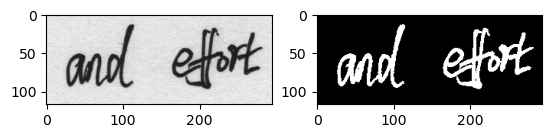

In [17]:
fig = plt.figure()
eng_ax = plt.subplot(1, 2, 1)
eng_ax.imshow(eng_test, cmap='gray')
eng_bin_Ax = plt.subplot(1, 2, 2)
eng_bin_Ax.imshow(eng_test_bin, cmap='gray')
fig.show()

In [18]:
test, bounding_boxes, segmented_image, labels = sd.simple_stroke_segment(eng_test_bin)
len(test)

52

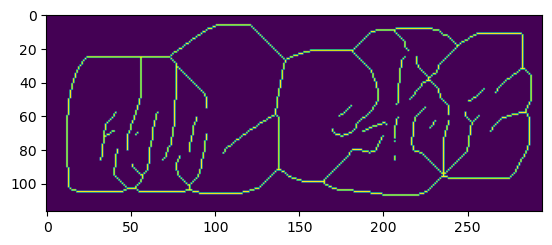

In [19]:
plt.imshow(labels)

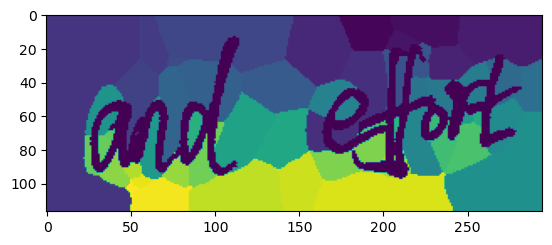

In [20]:
plt.imshow(segmented_image)

(slice(0, 81, None), slice(40, 67, None))


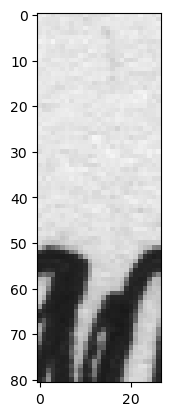

In [21]:
idx = 9
print(bounding_boxes[idx])
plt.imshow(eng_test[bounding_boxes[idx]])

/tmp/ipykernel_16578/2336598896.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  stroke_fig.show()


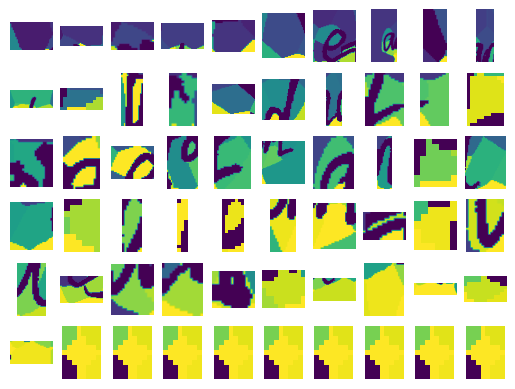

In [22]:
stroke_fig, stroke_axes = plt.subplots(6, 10)
count = 0
for row in stroke_axes:
    for ax in row:
        ax.axis('off')
        ax.imshow(test[count])
        count = min(count+1, len(test)-1)

stroke_fig.show()

In [23]:
model = adapt_resnet50((64, 64, 3))
model.compile()

In [24]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10010     
Total params: 25,646,722
Trainable params: 2,059,010
Non-trainable params: 23,587,712
_________________________________________________________________


In [25]:
height, width = test[0].shape
height, width

h = w = 64
h_d = h - height
w_d = h - width

top, bottom = h_d // 2, h_d - (h_d // 2)
top, bottom

left, right = w_d // 2, w_d - (w_d // 2)
left, right

test_padded = cv.copyMakeBorder(test[0].astype(float), top, bottom, left, right, cv.BORDER_CONSTANT, value = 0)
test_padded = cv.cvtColor(test_padded.astype(np.float32), cv.COLOR_GRAY2RGB)

In [26]:
test_padded.shape

(64, 64, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


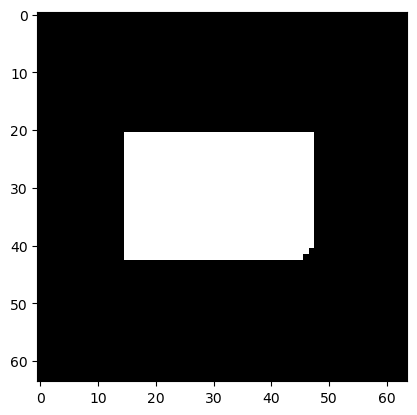

In [27]:
plt.imshow(test_padded)

In [28]:
fake_batch = test_padded.reshape(-1, 64, 64, 3)
model.predict(fake_batch)

array([[0.06258021, 0.06028033, 0.06589644, 0.07812516, 0.0425572 ,
        0.07216875, 0.09148106, 0.03484624, 0.08381956, 0.40824506]],
      dtype=float32)